# Why aggregate data to grids?

Why do we aggregate data to grids?  
**Discretization**  
Hard to analyze data in continuous space, but easy to analyze with discretized region. Defining spatial analysing units can discretize the region.  
**Comparable**  
All grids are with same size, their attributes are comparable under same standard.  
**Controllable**  
Under grid-based framework, aggregation accuracy is controllable. Defining smaller grids will improve the accuracy, but increase computing burden.  
**Efficient**  
Using TransBigData, GPS data can match to grids with small computational complexity. High computation speed for the matching between grids and GPS data.  

# Optimize gridding params

In TransBigData, the gridding framework is determined by the gridding params. Each of the gridding params can define a griding coordinate system. The params are as follows:

```python
params=(lonStart,latStart,deltaLon,deltaLat,theta)
```

However, how to choose an appropriate gridding params in our research is the most basic thing, which may have a great impact on the final analysis results. 

The selection of the grid depends on the data and the purpose analyzed.  
Suppose we want to use the grid system to analyze the vehicle travel trajectory. If the grid boundaries coincide with the road centerline, the vehicle travel through the road 
section will generate the GPS points along the grid boundry. There will be great differences in the grid sequence generated after matching GPS to grids even if the vehicles are passing through the same road section. In another word, a better grid coordinate system should be that the trajectory travel through the same path should have similar grid sequence.

A good idea is to input the urban road network data and optimize the grid parameters from the road network. However, for a gridding framework like TransBigData, this is not the best solution. The GPS data we want to analyze is not only the vehicle trajectory data and they do not have to follow a given road network. Moreover, the spatial feature of the road network is already included in the vehicle trajectory. Thus, the selection of gridding parameters should depend on the original spatial attributes of the GPS data. 

When analysing individual mobility data, the optimal grid selection criteria are also different. Since individuals usually stay more time and generate more data in their activity points, a better gridding should match these data into the same grid. The result should be that few grids occupy more data.

Here, we offer three methods to optimize the griding params: centerdist, gini and gridscount

In [ ]:
import pandas as pd
import geopandas as gpd
import transbigdata as tbd
#Read taxi gps data
tripdata = pd.read_csv(r'data/TaxiData-Sample.csv')
tripdata.columns = ['track_id','time','lon','lat','OpenStatus','Speed']

#Retain the data in given area
area = gpd.read_file(r'data/gis/szarea1.json')
tripdata = tbd.clean_outofshape(tripdata,area,col=['lon','lat'])

#Generate initial griding params
bounds = [113.6,22.4,114.8,22.9]
initialparams = tbd.grid_params(bounds,accuracy = 500)

# centerdist: Minimize the distance between grid center and GPS data

When a batch of data with close distance are distributed at the edge of the grid, the deviation of GPS data will cause these data to be matched into different grids. So one of the solution is to minimize the distance between grid center and GPS data.

Optimized index centerdist: 151.82636867376712
Optimized gridding params: [113.60349428461274, 22.403969555686768, 0.004872390756896538, 0.004496605206422906, 46.10806575231333]
Optimizing cost:


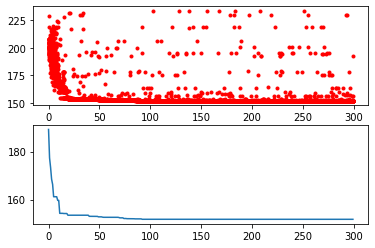

Result:


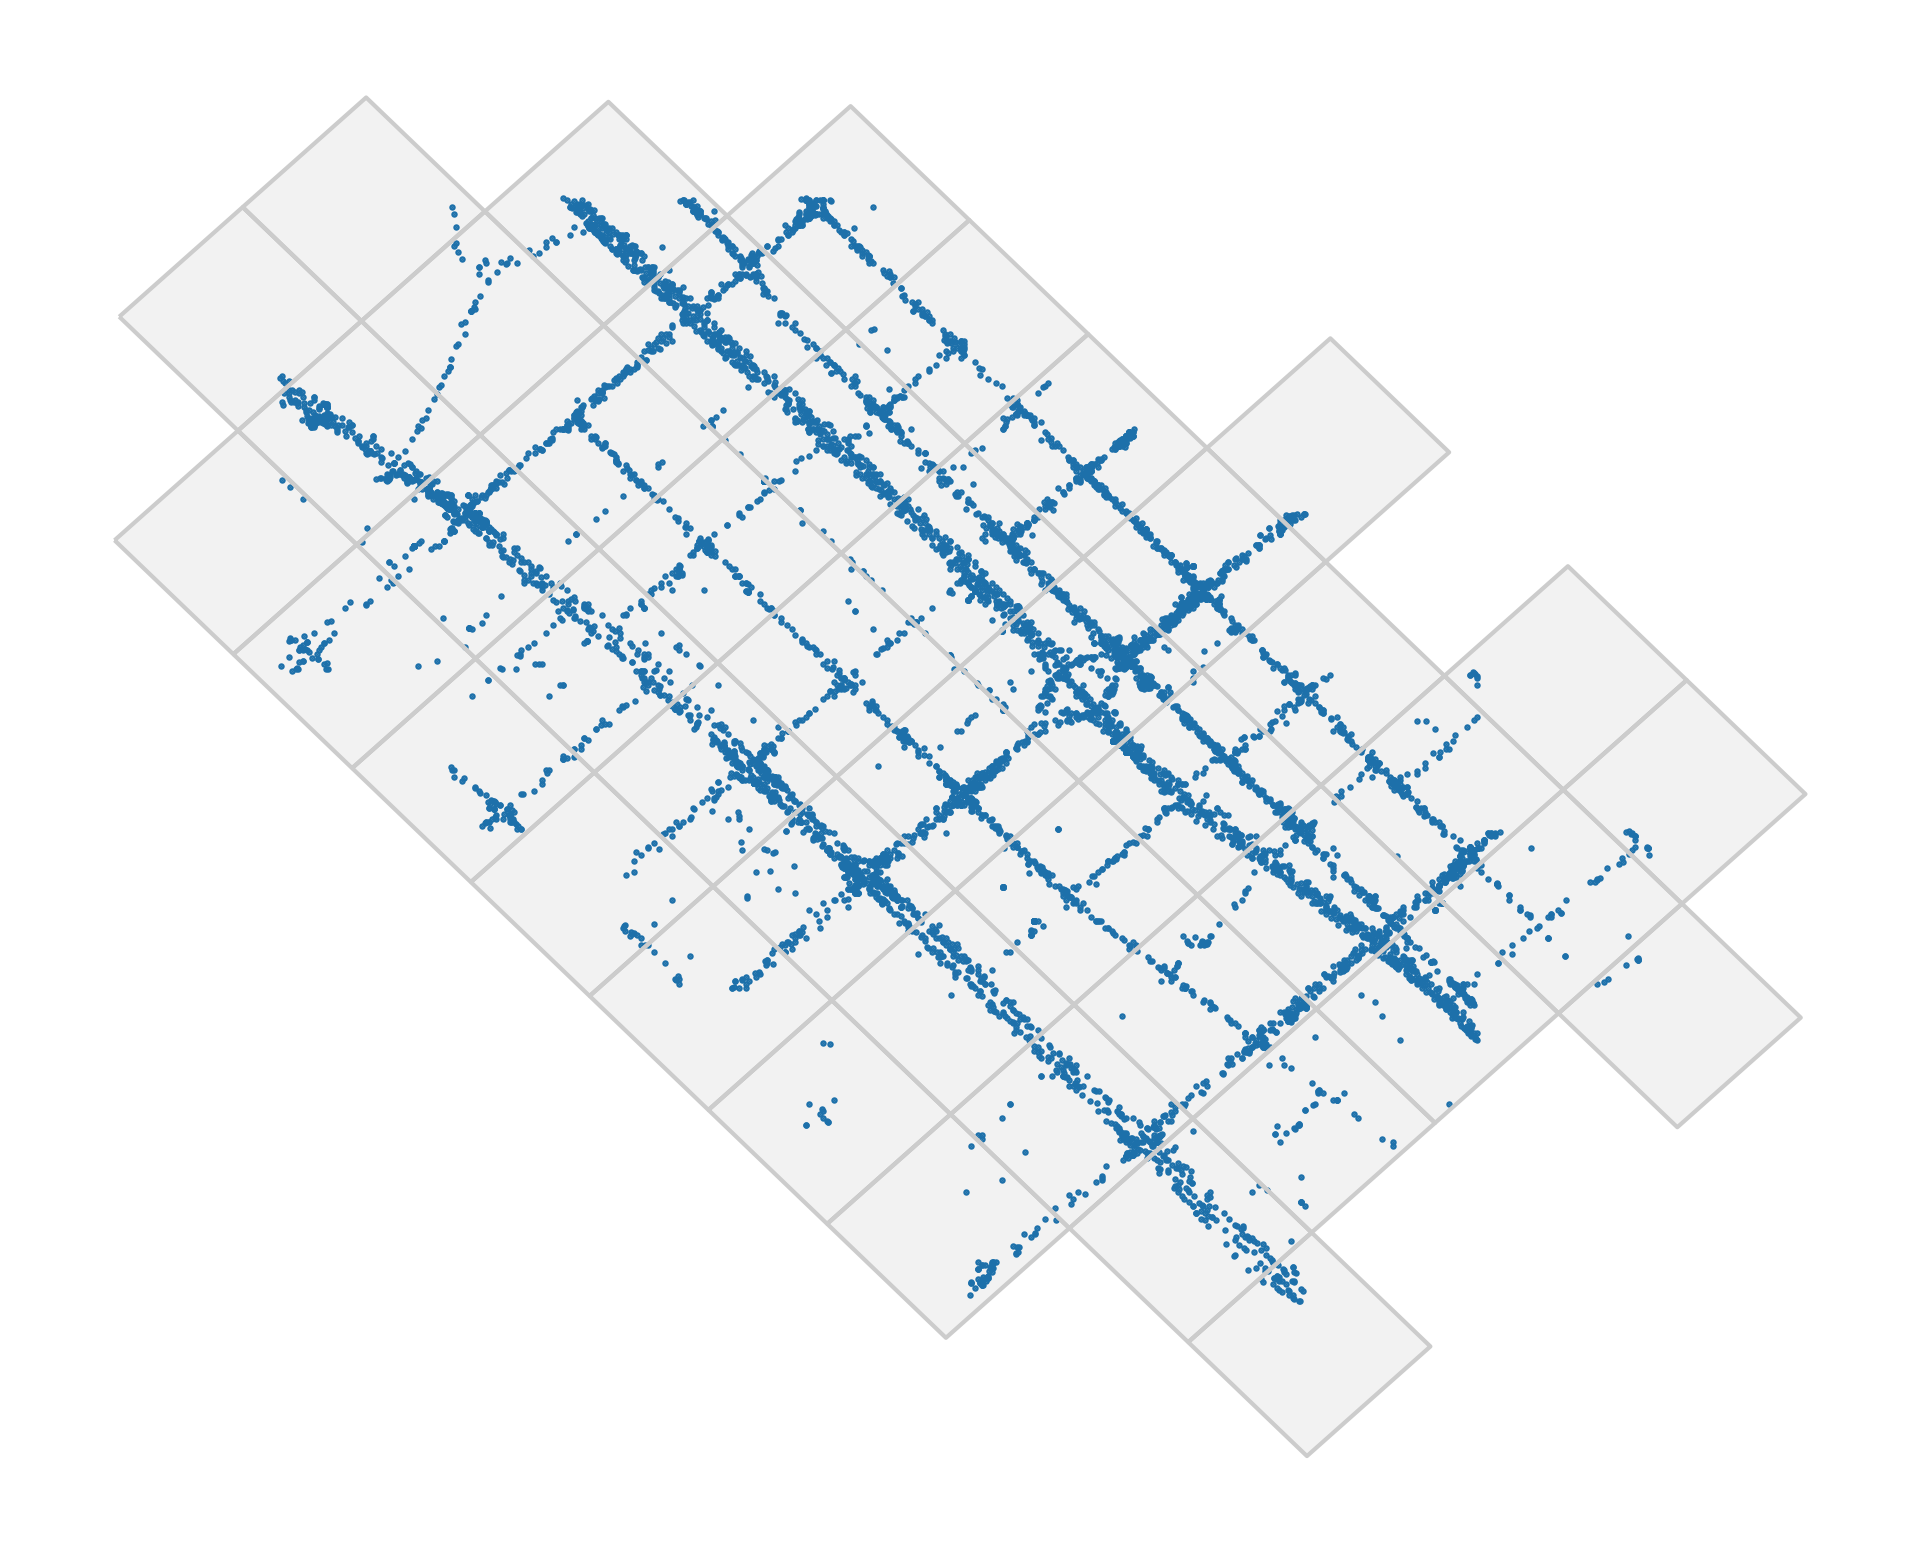

In [3]:
#Optimize gridding params
params_optimized = tbd.grid_params_optimize(tripdata,
                                            initialparams,
                                            col=['track_id','lon','lat'],
                                            method='centerdist',
                                            sample=0, #not sampling
                                            printlog=True)


# gini: Maximize the gini index

In economics, Gini index is a measure of statistical dispersion intended to represent the income inequality or the wealth inequality within a nation or a social group. Here, we can borrow the concept of Gini index to represent the distribution of GPS data in the grids. The higher of the Gini index represents that the data is more concentrated distribution in the given grids.  
The gini index is more helpful in analysing human mobility data. 

Optimized index gini: -0.5633413905933093
Optimized gridding params: [113.6030622621311, 22.400761656282935, 0.004872390756896538, 0.004496605206422906, 24.542707179822486]
Optimizing cost:


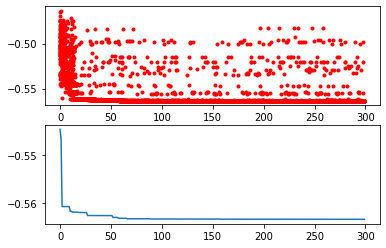

Result:


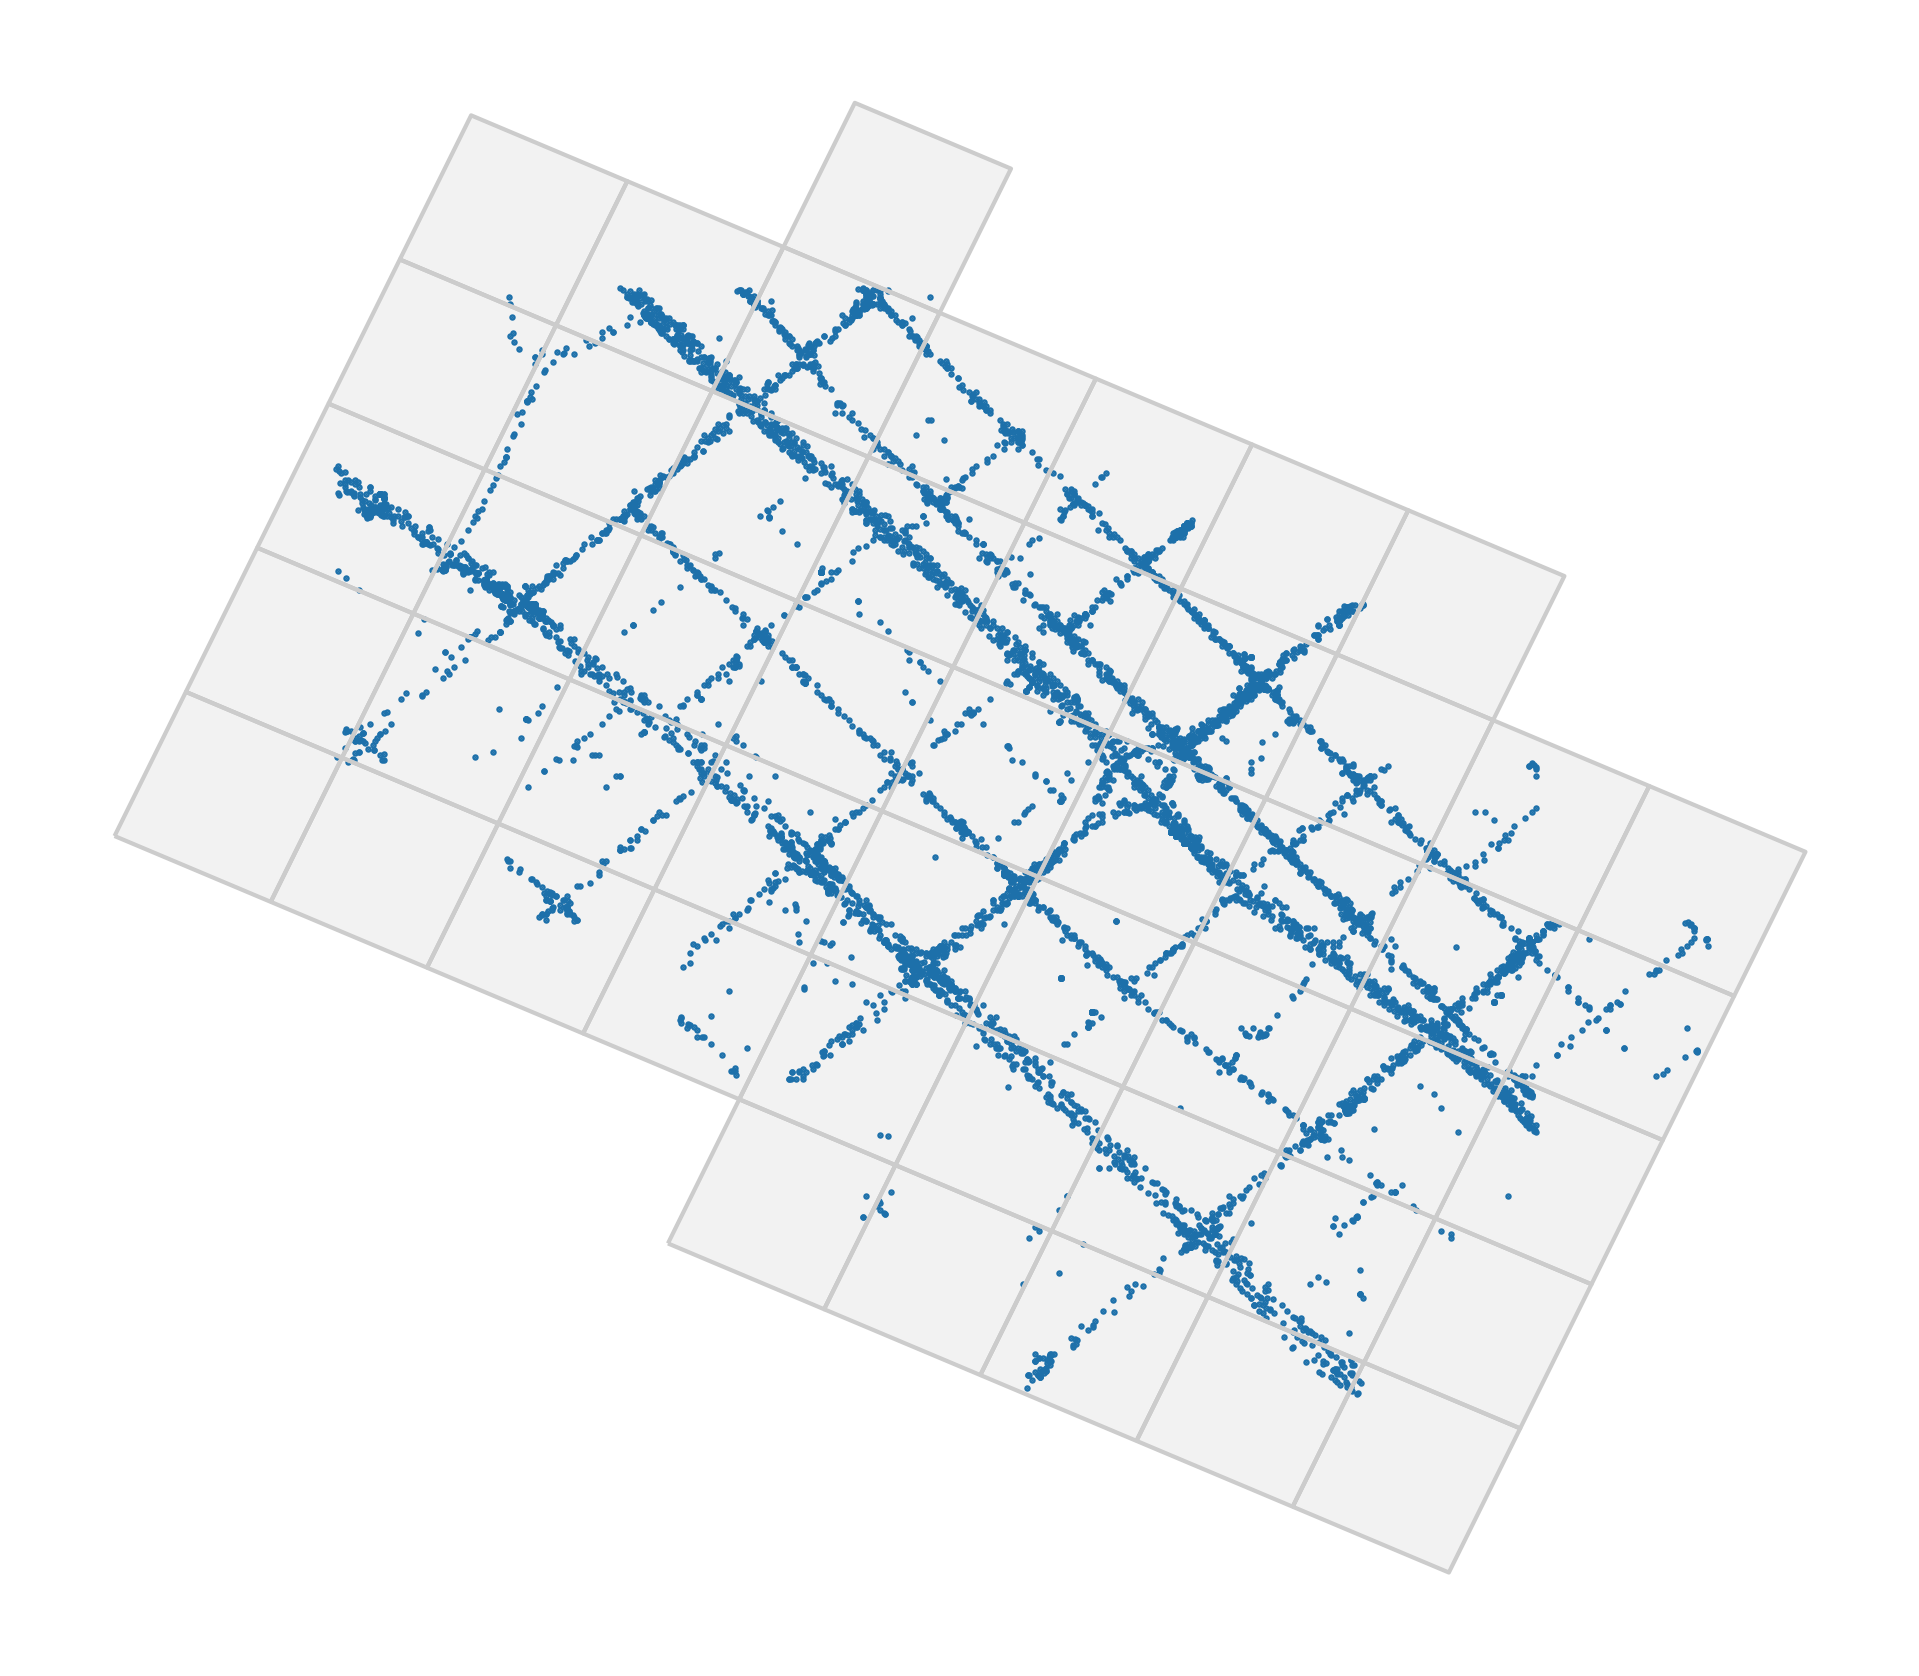

In [4]:
#Optimize griding params
params_optimized = tbd.grid_params_optimize(tripdata,
                                            initialparams,
                                            col=['track_id','lon','lat'],
                                            method='gini',
                                            sample=0, #not sampling
                                            printlog=True)


# gridscount: Minimize the average count of grids for individuals

Under this standard, each individual should appear in as few grids as possible.

Optimized index gridscount: 9.0
Optimized gridding params: [113.60290746109118, 22.401015312800396, 0.004872390756896538, 0.004496605206422906, 42.68153918072262]
Optimizing cost:


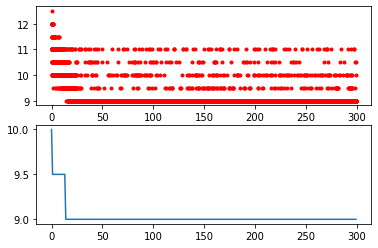

Result:


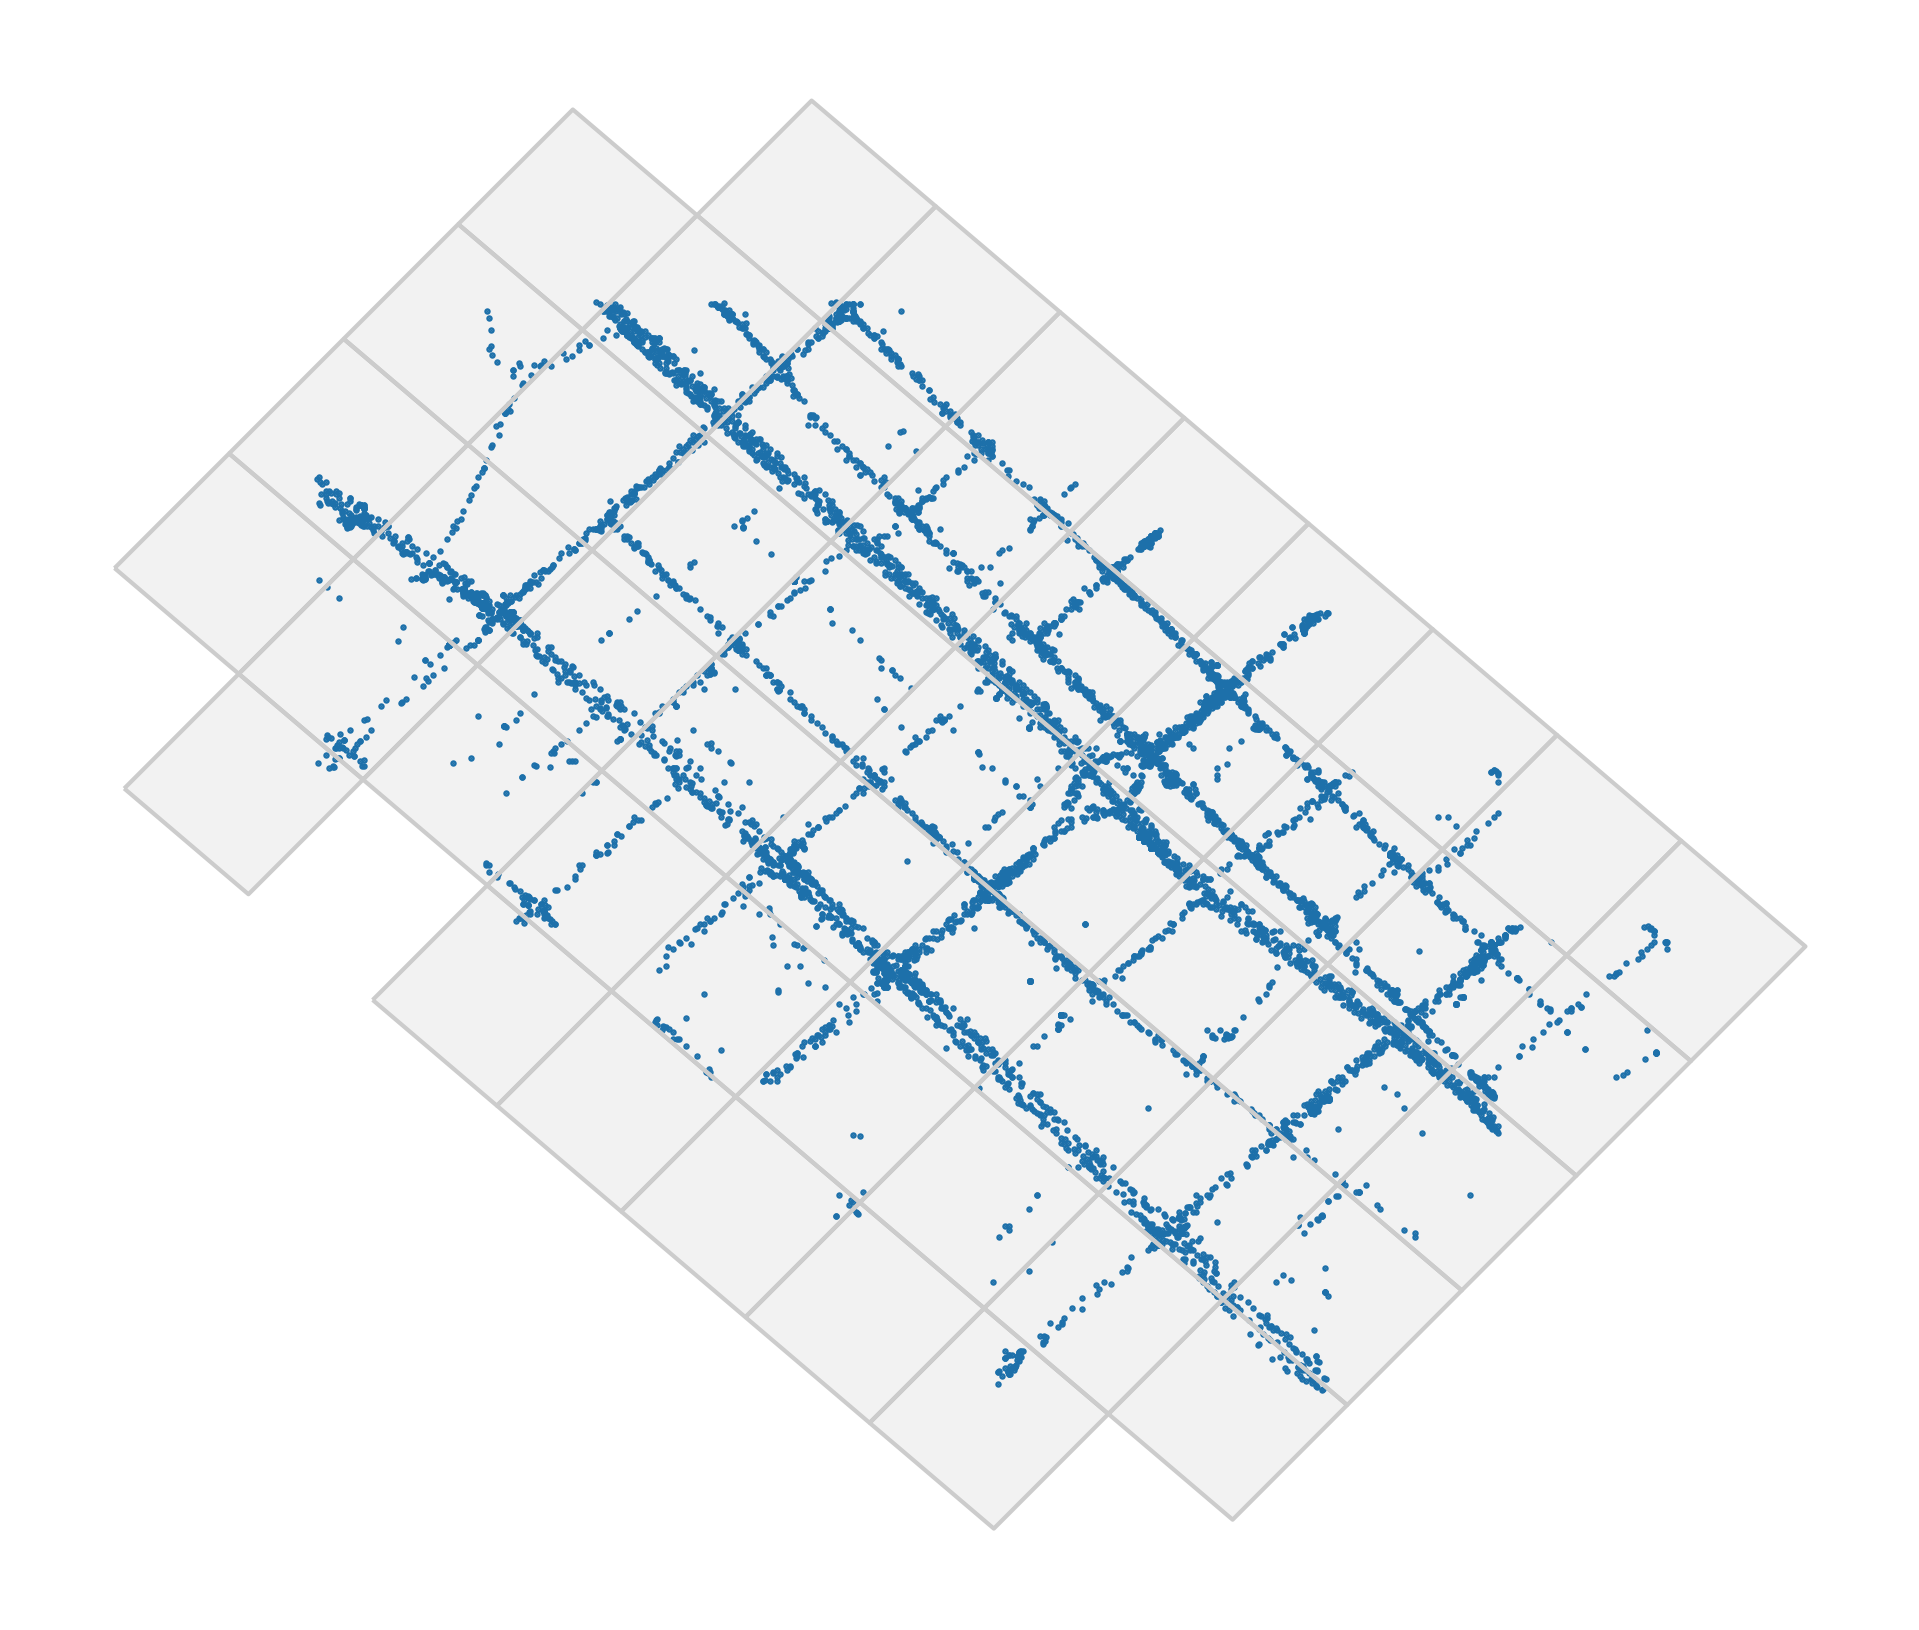

In [5]:
#Optimize griding params
params_optimized = tbd.grid_params_optimize(tripdata,
                                            initialparams,
                                            col=['track_id','lon','lat'],
                                            method='gridscount',
                                            sample=0, #not sampling
                                            printlog=True)


# Bus GPS

For buses on the same bus line, they always follow the same route and pass through the same road section. Therefore, it can be used to analyze the grid sequence corresponding to their trajectory.

In [8]:
import pandas as pd
import geopandas as gpd
import transbigdata as tbd
#Read taxi gps data
BUS_GPS= pd.read_csv(r'data/busgps.csv',header = None)
BUS_GPS.columns = ['GPSDateTime', 'LineId', 'LineName', 'NextLevel', 'PrevLevel',
       'Strlatlon', 'ToDir', 'VehicleId', 'VehicleNo', 'unknow']
#Convert the time column to datetime type
BUS_GPS['GPSDateTime'] = pd.to_datetime(BUS_GPS['GPSDateTime'])
#Slice the latitude and longitude string
BUS_GPS['lon'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[0])
BUS_GPS['lat'] = BUS_GPS['Strlatlon'].apply(lambda r:r.split(',')[1])
#Convert coordinates
BUS_GPS['lon'],BUS_GPS['lat'] = tbd.gcj02towgs84(BUS_GPS['lon'].astype(float),BUS_GPS['lat'].astype(float))
BUS_GPS.head(5)

,GPSDateTime,LineId,LineName,NextLevel,PrevLevel,Strlatlon,ToDir,VehicleId,VehicleNo,unknow,lon,lat
0,2019-01-16 23:59:59,7100,71,2,1,"121.335413,31.173188",1,沪D-R7103,Z5A-0021,1,121.330858,31.175129
1,2019-01-17 00:00:00,7100,71,2,1,"121.334616,31.172271",1,沪D-R1273,Z5A-0002,1,121.330063,31.174214
2,2019-01-17 00:00:00,7100,71,24,23,"121.339955,31.173025",0,沪D-R5257,Z5A-0020,1,121.335390,31.174958
3,2019-01-17 00:00:01,7100,71,14,13,"121.409491,31.20433",0,沪D-R5192,Z5A-0013,1,121.404843,31.206179
4,2019-01-17 00:00:03,7100,71,15,14,"121.398615,31.200253",0,沪D-T0951,Z5A-0022,1,121.393966,31.202103


In [16]:
import warnings
warnings.filterwarnings('ignore')

shp = r'data/busline.json'
linegdf = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
line = linegdf.iloc[:1].copy()

shp = r'data/busstop.json'
stop = gpd.GeoDataFrame.from_file(shp,encoding = 'gbk')
stop = stop[stop['linename'] == '71路(延安东路外滩-申昆路枢纽站)']

arriveinfo,data_project = tbd.busgps_arriveinfo(BUS_GPS,line,stop,projectoutput=True)

Cleaning data...
Position matching......
Matching arrival and leaving info.........................................................................................................................................................

In [78]:
onewaytime = tbd.busgps_onewaytime(arriveinfo,
                                   start = '延安东路外滩',
                                   end = '申昆路枢纽站',col = ['VehicleId','stopname', 'arrivetime', 'leavetime'])
tmpdata = data_project[['VehicleId','GPSDateTime','lon','lat']]
onewaytime['ID'] = range(len(onewaytime))
odata = onewaytime[['VehicleId','time','stopname','ID']].copy()
odata.columns = ['VehicleId','GPSDateTime', 'stopname','ID']
odata.loc[:,'flag'] = 1
ddata = onewaytime[['VehicleId','time1','stopname1','ID']].copy()
ddata.columns = ['VehicleId','GPSDateTime', 'stopname','ID']
ddata.loc[:,'flag'] = -1
data1 = pd.concat([tmpdata,odata,ddata])
data1 = data1.sort_values(by = ['VehicleId','GPSDateTime'])
data1['flag'] = data1['flag'].fillna(0)
data1['flag'] = data1.groupby('VehicleId')['flag'].cumsum()
data1['ID'] = data1['ID'].ffill()
data1 = pd.merge(data1[data1['flag']==1],onewaytime[['ID','direction']])
data1 = data1[-data1['lon'].isnull()]

In [94]:
direction1 = data1[data1['direction']=='申昆路枢纽站-延安东路外滩']
direction2 = data1[data1['direction']=='延安东路外滩-申昆路枢纽站']

In [95]:
direction1

,VehicleId,GPSDateTime,lon,lat,stopname,ID,flag,direction,geometry
1,1,2019-01-17 06:19:54,121.328719,31.171010,NaN,184.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.32872 31.17101)
2,1,2019-01-17 06:20:09,121.330272,31.171625,NaN,184.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.33027 31.17162)
3,1,2019-01-17 06:20:24,121.332162,31.172555,NaN,184.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.33216 31.17255)
4,1,2019-01-17 06:20:39,121.332908,31.173082,NaN,184.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.33291 31.17308)
5,1,2019-01-17 06:20:54,121.333387,31.173387,NaN,184.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.33339 31.17339)
...,...,...,...,...,...,...,...,...,...
57840,148,2019-01-17 17:30:03,121.480618,31.233096,NaN,374.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.48062 31.23310)
57841,148,2019-01-17 17:30:33,121.482651,31.232892,NaN,374.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.48265 31.23289)
57842,148,2019-01-17 17:30:48,121.482829,31.232971,NaN,374.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.48283 31.23297)
57843,148,2019-01-17 17:31:08,121.483096,31.233087,NaN,374.0,1.0,申昆路枢纽站-延安东路外滩,POINT (121.48310 31.23309)


In [98]:
bounds = [121.327083,31.166373,121.485128,31.234147]
initialparams = tbd.grid_params(bounds,accuracy = 500)

Optimized index centerdist: 166.0684510476714
Optimized gridding params: [121.32843476593014, 31.16832704593073, 0.0052569621781188855, 0.004496605206422906, 63.4562644981885]
Optimizing cost:


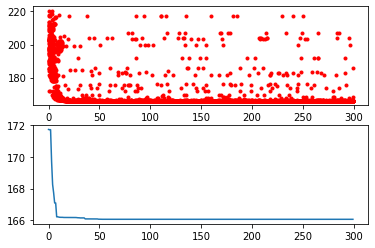

Result:


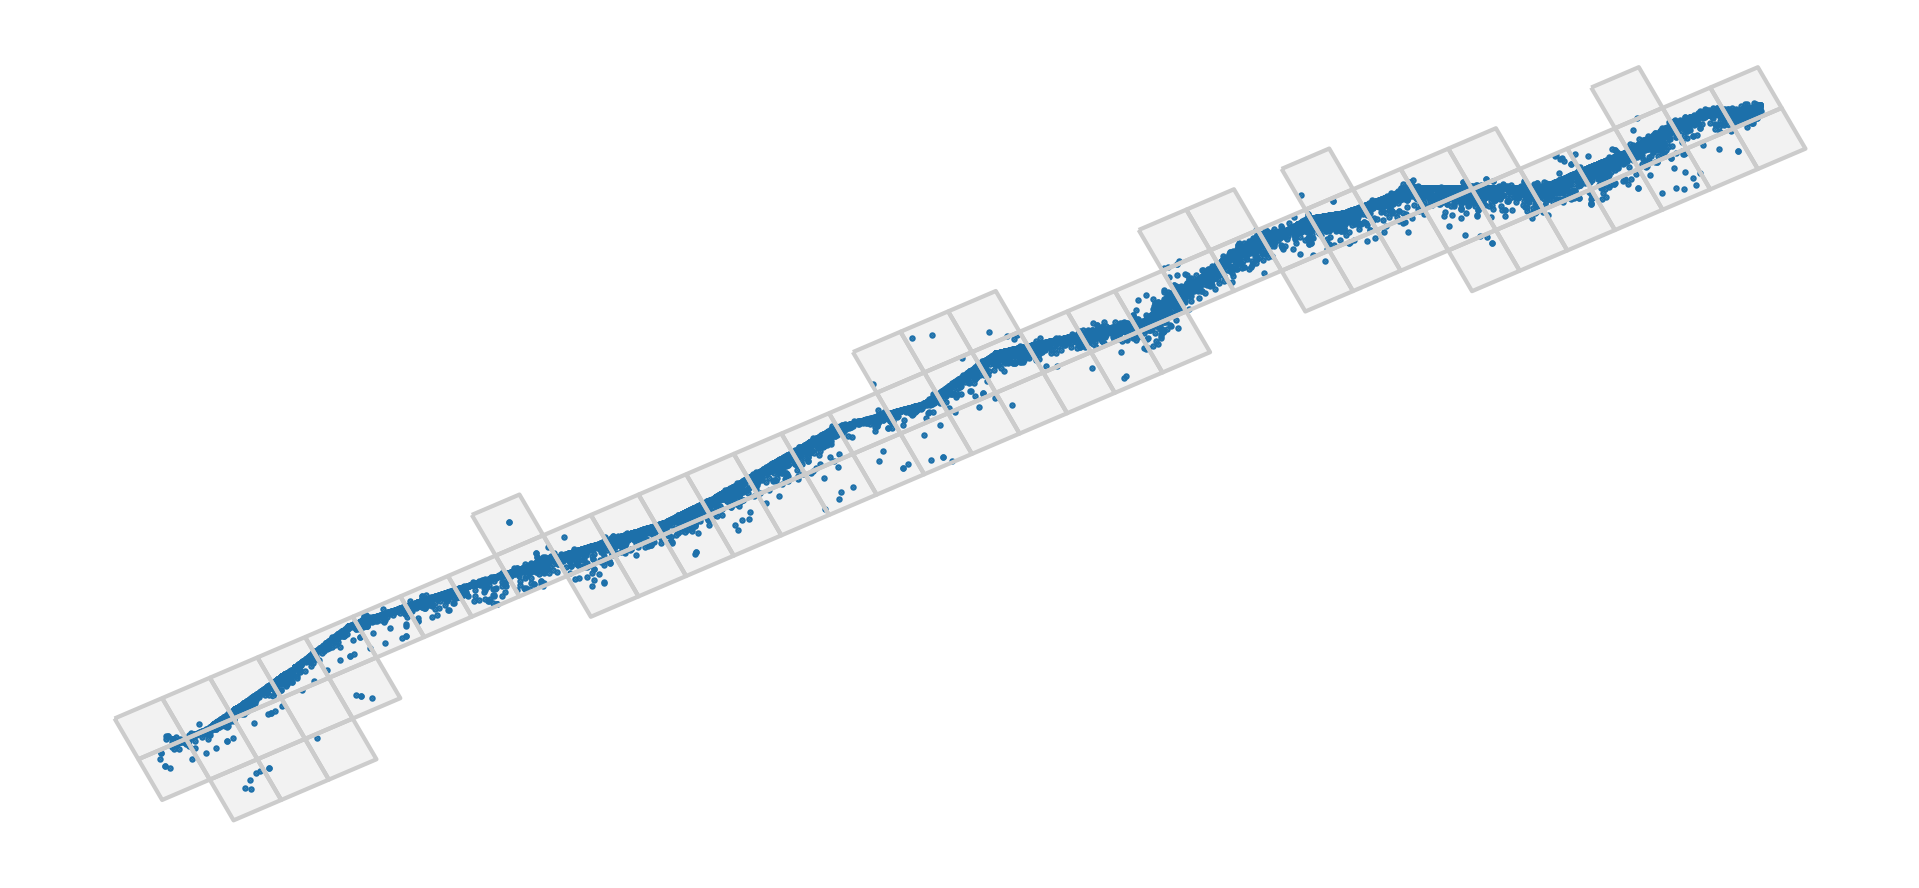

In [100]:
#Optimize gridding params
params_optimized = tbd.grid_params_optimize(direction1,
                                            initialparams,
                                            col=['VehicleId','lon','lat'],
                                            method='centerdist',
                                            sample=0, #not sampling
                                            printlog=True)


Optimized index gini: -0.6547434711589554
Optimized gridding params: [121.3297560531833, 31.16667578009822, 0.0052569621781188855, 0.004496605206422906, 29.29249364343772]
Optimizing cost:


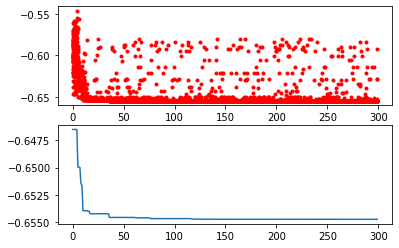

Result:


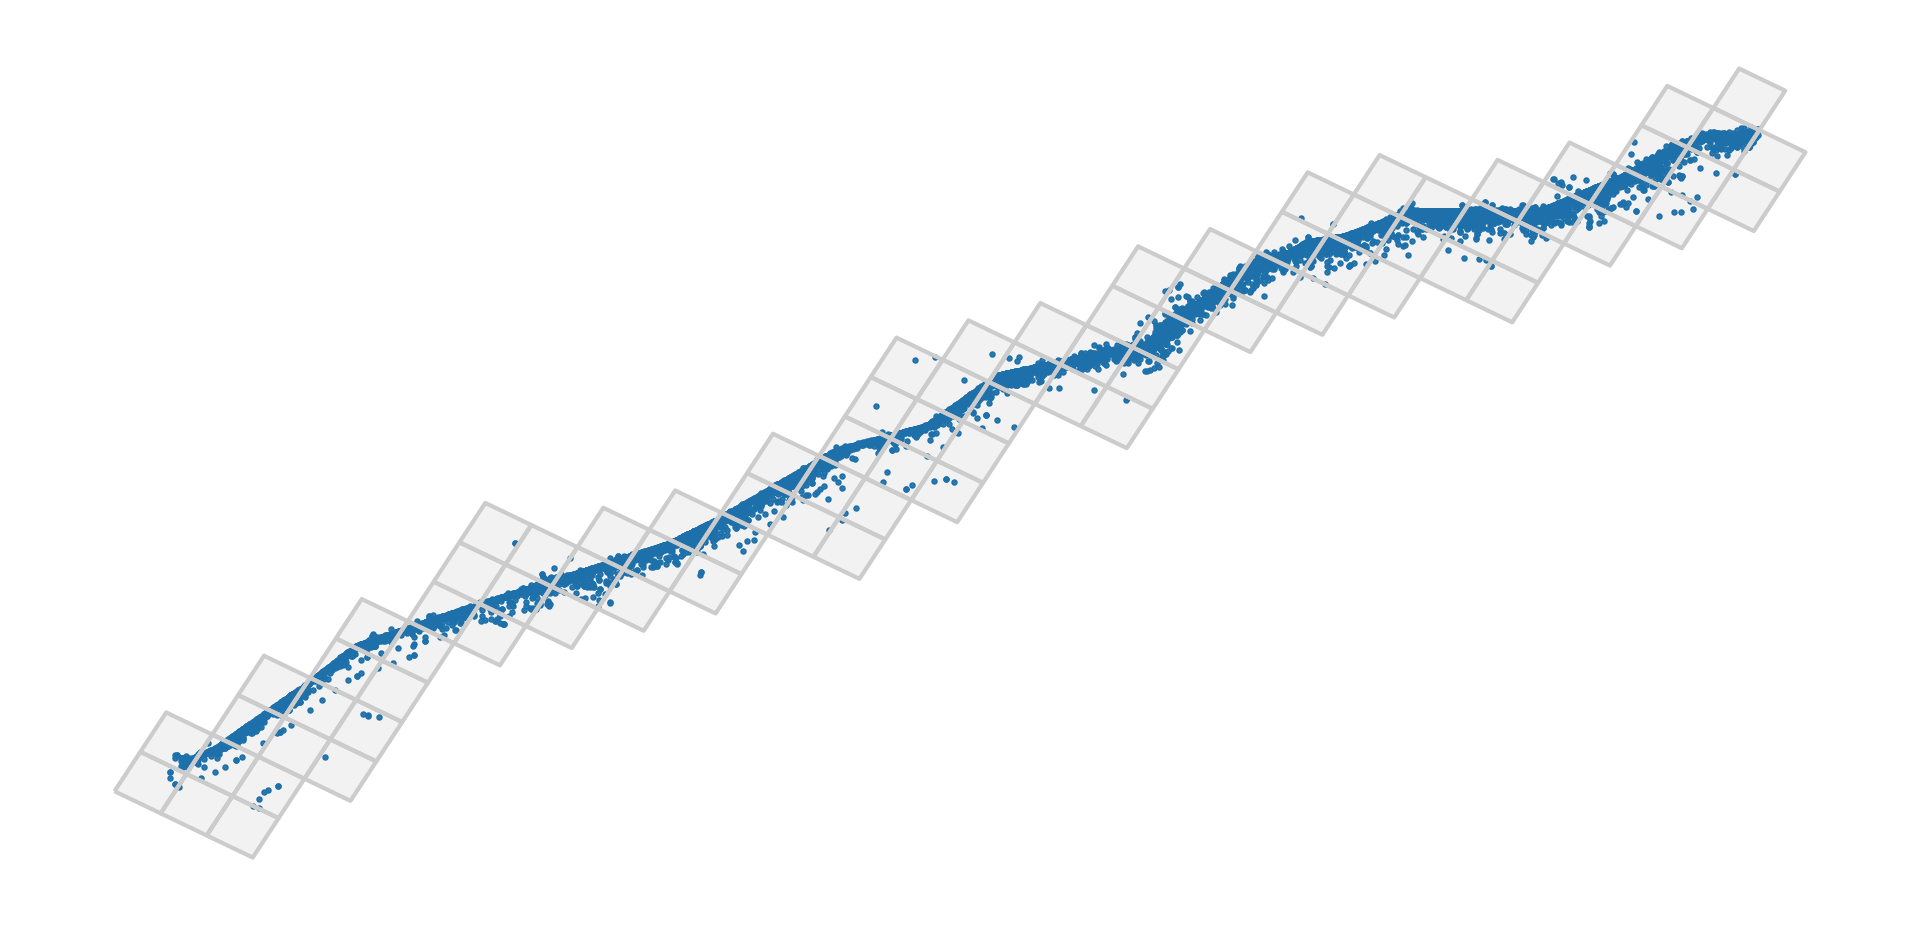

In [101]:
#Optimize gridding params
params_optimized = tbd.grid_params_optimize(direction1,
                                            initialparams,
                                            col=['VehicleId','lon','lat'],
                                            method='gini',
                                            sample=0, #not sampling
                                            printlog=True)


Optimized index gridscount: 34.0
Optimized gridding params: [121.33171568479692, 31.169199280775125, 0.0052569621781188855, 0.004496605206422906, 63.46533854094352]
Optimizing cost:


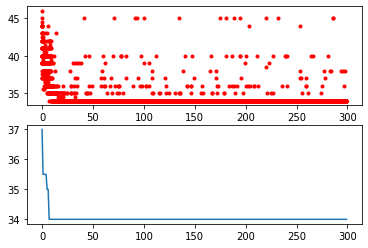

Result:


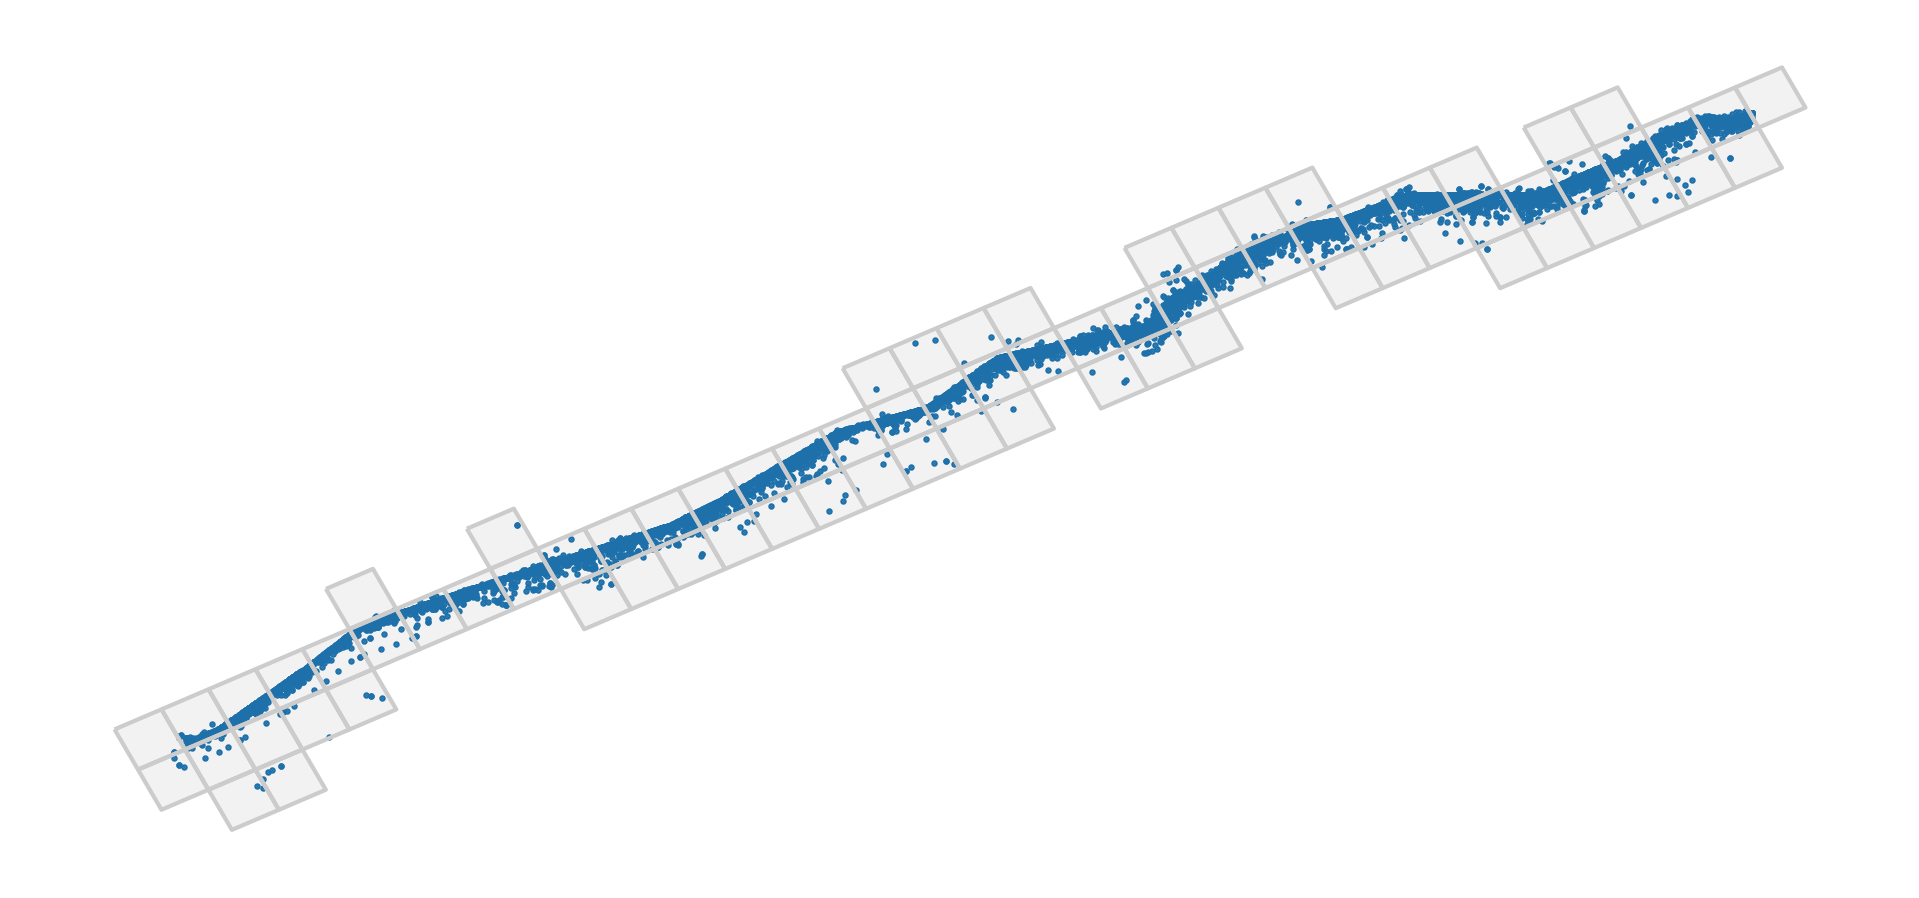

In [102]:
#Optimize gridding params
params_optimized = tbd.grid_params_optimize(direction1,
                                            initialparams,
                                            col=['VehicleId','lon','lat'],
                                            method='gridscount',
                                            sample=0, #not sampling
                                            printlog=True)
